# Image Classification

## Table of Contents
* [1. Setup and Load Data](#setup)
    - [1.1 Install Depedencies and Setup](#install)
    - [1.2 Remove Nonimages](#remove)
    - [1.3 Load Data](#load)
* [2. Preprocess Data](#preprocess)
    - [2.1 Data Augmentation](#augment)
    - [2.2 Configure the Dataset for Performance](#configure)
    - [2.3 Split Dataset](#split)
* [3. Deep Model](#deep_model)
    - [3.1 Build Deep Learning Model](#build_model)
    - [3.2 Train Model](#train)
    - [3.3 Plot Performance](#performance)
* [4. Evaluate Performance](#evaluation)
    - [4.1 K-Fold Cross Validation](#kfold)
    - [4.2 Testing Multiple Images](#test_multi)
    - [4.3 Testing Single Images](#test_single)
* [5. Save Model](#saving_model)

# 1. Setup and Load Data <a id="setup"></a>

### 1.1 Install Dependencies and Setup <a id="install"></a>

In [ ]:
!pip install tensorflow==2.10 tensorflow-gpu==2.10 opencv-python matplotlib

In [1]:
import tensorflow as tf
import os

In [2]:
## Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Remove Nonimages <a id="remove"></a>

In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data'
image_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
def remove_nonimage(image):
    try:
        img = cv2.imread(image)
        extension = imghdr.what(image)

        if extension not in image_extensions:
            print('Image not in extension list {}'.format(image))
            os.remove(image)
    except Exception as e:
        print('Issue with image {}'.format(image))
        os.remove(image)

for image_class in os.listdir(os.path.join(data_dir, 'training')):
    for image in os.listdir(os.path.join(data_dir, 'training', image_class)):
        image_path = os.path.join(data_dir, 'training', image_class, image)
        remove_nonimage(image_path)

### 1.3 Load Data <a id="load"></a>

Loads images into a data image pipeline. The <span style="color:#5886e8">image_dataset_from_directory</span> transforms data into a consistent shape and batch.  
All images transform to size 256x256 by default.

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
data_set = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'training'), 
    batch_size = 32)

Found 5652 files belonging to 6 classes.


In [8]:
class_names = data_set.class_names
class_names

['basketball',
 'bowling ball',
 'soccerball',
 'star',
 'tennisball',
 'volleyball']

In [74]:
data_iterator = data_set.as_numpy_iterator()
image, category = data_iterator.next()
print(image.shape)

(32, 256, 256, 3)


<span style="color:#5886e8">batch</span> has 2 indexes the image and the class of the image (int)

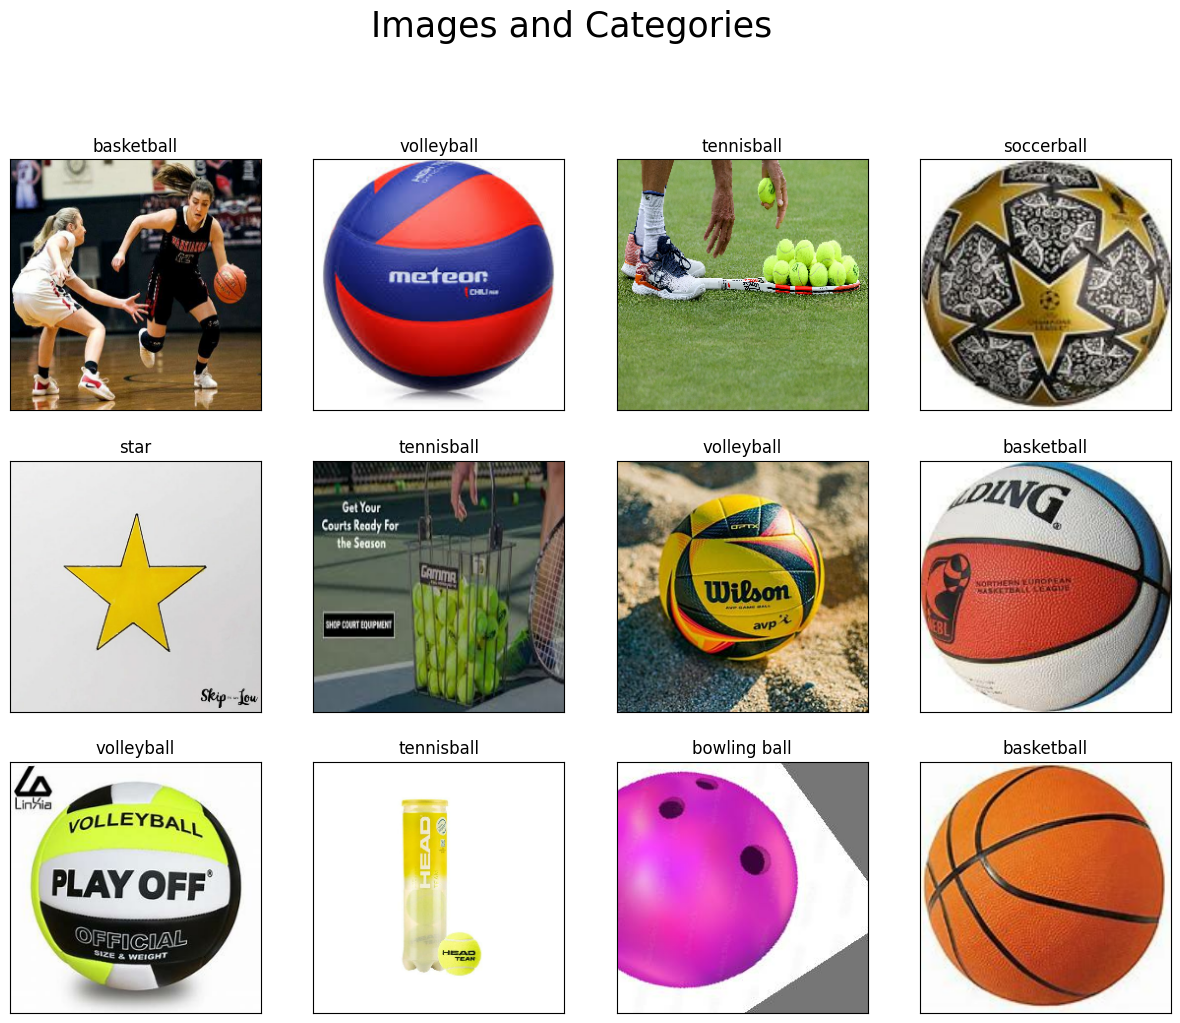

In [75]:
figsize = (15,15)
figure = plt.figure(figsize=figsize)
figure.suptitle("Images and Categories", fontsize=25)

for i in range(12):
    plt.subplot(4,4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i].astype(np.uint8))
    plt.title(class_names[category[i]])
plt.show()    

# 2. Preprocessing Data <a id="preprocess"></a>

### 2.1 Data Augmentation <a id="augment"></a>

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images.  
This helps expose the model to more aspects of the data and generalize better.

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(
        rotation_range=45,     # Random rotation between 0 and 45
        width_shift_range=0.2,   # % shift
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant', cval=125)    # Also try nearest, constant, reflect, wrap

In [13]:
for batch in datagen.flow_from_directory(directory= os.path.join(data_dir, 'folder_to_augment'), 
                                         batch_size=1000,  
                                         target_size=(256, 256),
                                         color_mode="rgb",
                                         save_to_dir=os.path.join(data_dir, 'augmented'), 
                                         save_prefix='aug', 
                                         save_format='jpg'):
    i += 1
    if i > 31:
        break

Found 0 images belonging to 0 classes.


### 2.2 Configure Dataset for Performance <a id="configure"></a>
* Scale the images values to be between 0-1 by dividing by 255. This helps our deep learning model journalize faster.   
* Prefectch data to overlap executing the training step and the reading data step.  
* Cache the dataset so file opening and data reading are done in the first epoch, then the next epochs will reuse the data cached.

In [14]:
data_scaled = data_set.map(lambda x, y: (x/255, y))

In [15]:
data_batch = data_scaled.as_numpy_iterator().next()

# Checking scaling
print(data_batch[0][0].min(), data_batch[0][0].max())

0.0 1.0


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
data_scaled = data_scaled.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

### 2.3 Split Data <a id="split"></a>

In [17]:
training = data_scaled.take(int(len(data_scaled)*.8))
validation = data_scaled.skip(int(len(data_scaled)*.8)).take(int(len(data_scaled)*.2))

# 3. Deep Model <a id="deep_model"></a>

### 3.1 Build Deep Learning Model <a id="build_model"></a>

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [48]:
model = Sequential()

In [49]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names)))

In [50]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [51]:
# Save weights to reset model for testing
saved_weights = model.get_weights()

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 conv2d_8 (Conv2D)           (None, 58, 58, 32)       

### 3.2 Train Model <a id="train"></a>

In [53]:
history = model.fit(training, epochs=20, validation_data=validation)

Epoch 1/20
141/141 [==============================] - 4s 24ms/step - loss: 1.2483 - accuracy: 0.5196 - val_loss: 0.9315 - val_accuracy: 0.6661
Epoch 2/20
141/141 [==============================] - 3s 23ms/step - loss: 0.8773 - accuracy: 0.6858 - val_loss: 0.6449 - val_accuracy: 0.7839
Epoch 3/20
141/141 [==============================] - 3s 21ms/step - loss: 0.6750 - accuracy: 0.7600 - val_loss: 0.5596 - val_accuracy: 0.8161
Epoch 4/20
141/141 [==============================] - 3s 21ms/step - loss: 0.5120 - accuracy: 0.8236 - val_loss: 0.3448 - val_accuracy: 0.9027
Epoch 5/20
141/141 [==============================] - 4s 29ms/step - loss: 0.3897 - accuracy: 0.8780 - val_loss: 0.2439 - val_accuracy: 0.9393
Epoch 6/20
141/141 [==============================] - 3s 22ms/step - loss: 0.2882 - accuracy: 0.9058 - val_loss: 0.2034 - val_accuracy: 0.9312
Epoch 7/20
141/141 [==============================] - 3s 21ms/step - loss: 0.2057 - accuracy: 0.9338 - val_loss: 0.1145 - val_accuracy: 0.9688

### 3.3 Plot Performance <a id="performance"><a/>

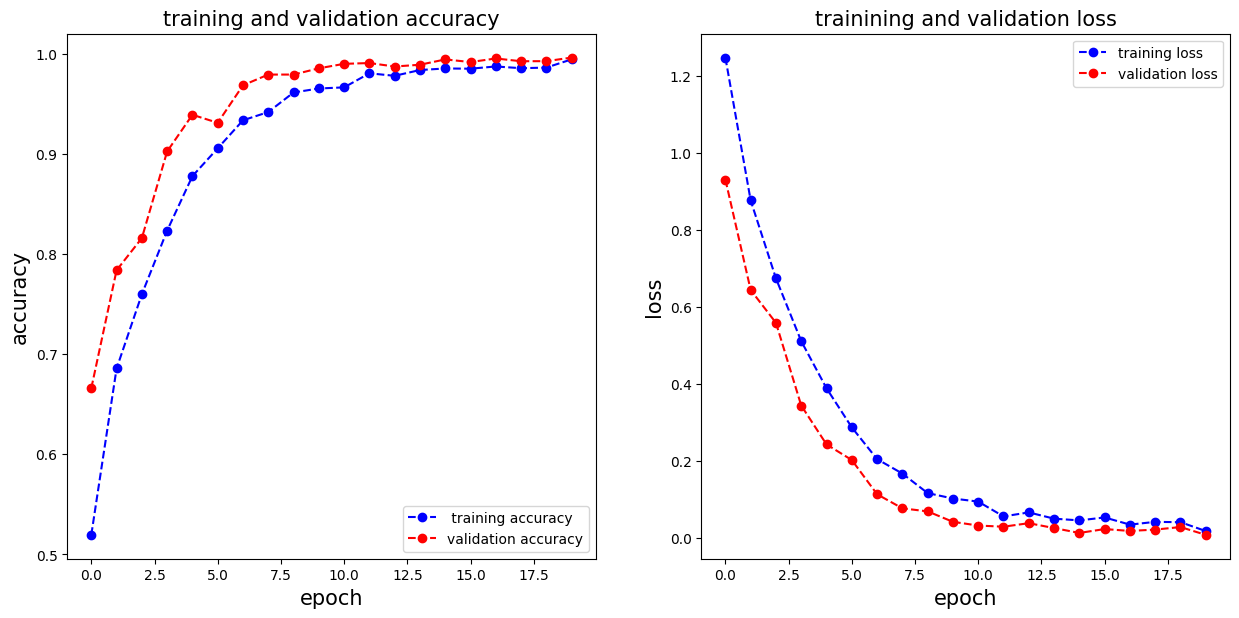

In [54]:
figure = plt.figure(figsize=(15,15))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label = ' training accuracy')
plt.plot(history.history['val_accuracy'], 'ro--', label = 'validation accuracy')
plt.title('training and validation accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend()


# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label = 'training loss')
plt.plot(history.history['val_loss'], 'ro--', label = 'validation loss')
plt.title('trainining and validation loss', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend()

plt.show()

# 4. Evaluate Performance <a id='evaluation'></a>

### 4.1 K-Fold Cross Validation <a id="kfold"></a>

In [26]:
import math
from sklearn.metrics import classification_report

In [76]:
# Get score of predictions in the batch
def prediction_score(prediction):
    value_list = []
    
    for i in range(len(prediction)):
        score = tf.nn.softmax(prediction[i])
        value_list.append(np.argmax(score))
    return value_list

# Return list of predictions score and actual score
def get_test_results(test):
    test_score = []
    prediction_list = []
    
    for batch in test.as_numpy_iterator():
        imgs, val = batch

        predict = model.predict(imgs, verbose = 0)
        prediction_list = np.append(prediction_list, prediction_score(predict))
        test_score = np.append(test_score, val)
    
    return prediction_list, test_score

In [28]:
def kfold_validation(data, k_fold):
    data_len = len(data)

    for k in range(k_fold):
        predict_list = []
        test_list = []
        percent = 1. / k_fold
        
        # Split train and test
        first_seg = int(round(data_len*(percent*k)))
        test_seg = int(round(data_len*percent))
        second_seg = int(round(data_len*((1-percent) - percent*k)))

        t1 = data.take(first_seg)
        test = data.skip(first_seg).take(test_seg)
        t2 = data.skip(first_seg + test_seg).take(second_seg)
        train = t1.concatenate(t2)
        
        # Reset weights and train model folds
        model.set_weights(saved_weights)
        model.fit(train, epochs=10, verbose=0)
        
        # Put results on a list
        predictions, test_score = get_test_results(test)
        predict_list = np.append(predict_list, predictions)
        test_list = np.append(test_list, test_score)
        
        print(f"----------------------- Fold {k+1} -----------------------")
        print(classification_report(test_list, predict_list))

In [47]:
kfold_validation(training, 5)

----------------------- Fold 1 -----------------------
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       162
         1.0       0.88      0.98      0.93       154
         2.0       0.95      0.95      0.95       185
         3.0       1.00      1.00      1.00        47
         4.0       0.98      0.96      0.97       182
         5.0       0.97      0.93      0.95       166

    accuracy                           0.96       896
   macro avg       0.96      0.96      0.96       896
weighted avg       0.96      0.96      0.96       896

----------------------- Fold 2 -----------------------
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       165
         1.0       0.94      0.97      0.96       160
         2.0       1.00      0.93      0.96       175
         3.0       0.98      0.98      0.98        46
         4.0       0.98      0.96      0.97       187
         5.0       0.9

### 4.2 Test Multiple Images <a id="test_multi"></a>

In [65]:
testing = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'), batch_size=64)
scaled_test = testing.map(lambda x, y: (x/255, y))

testing_iterator = scaled_test.as_numpy_iterator()
batch = testing_iterator.next()

Found 42 files belonging to 6 classes.


In [66]:
test_category = testing.class_names
case_score = batch[1]
test_list = []
predict_list = []

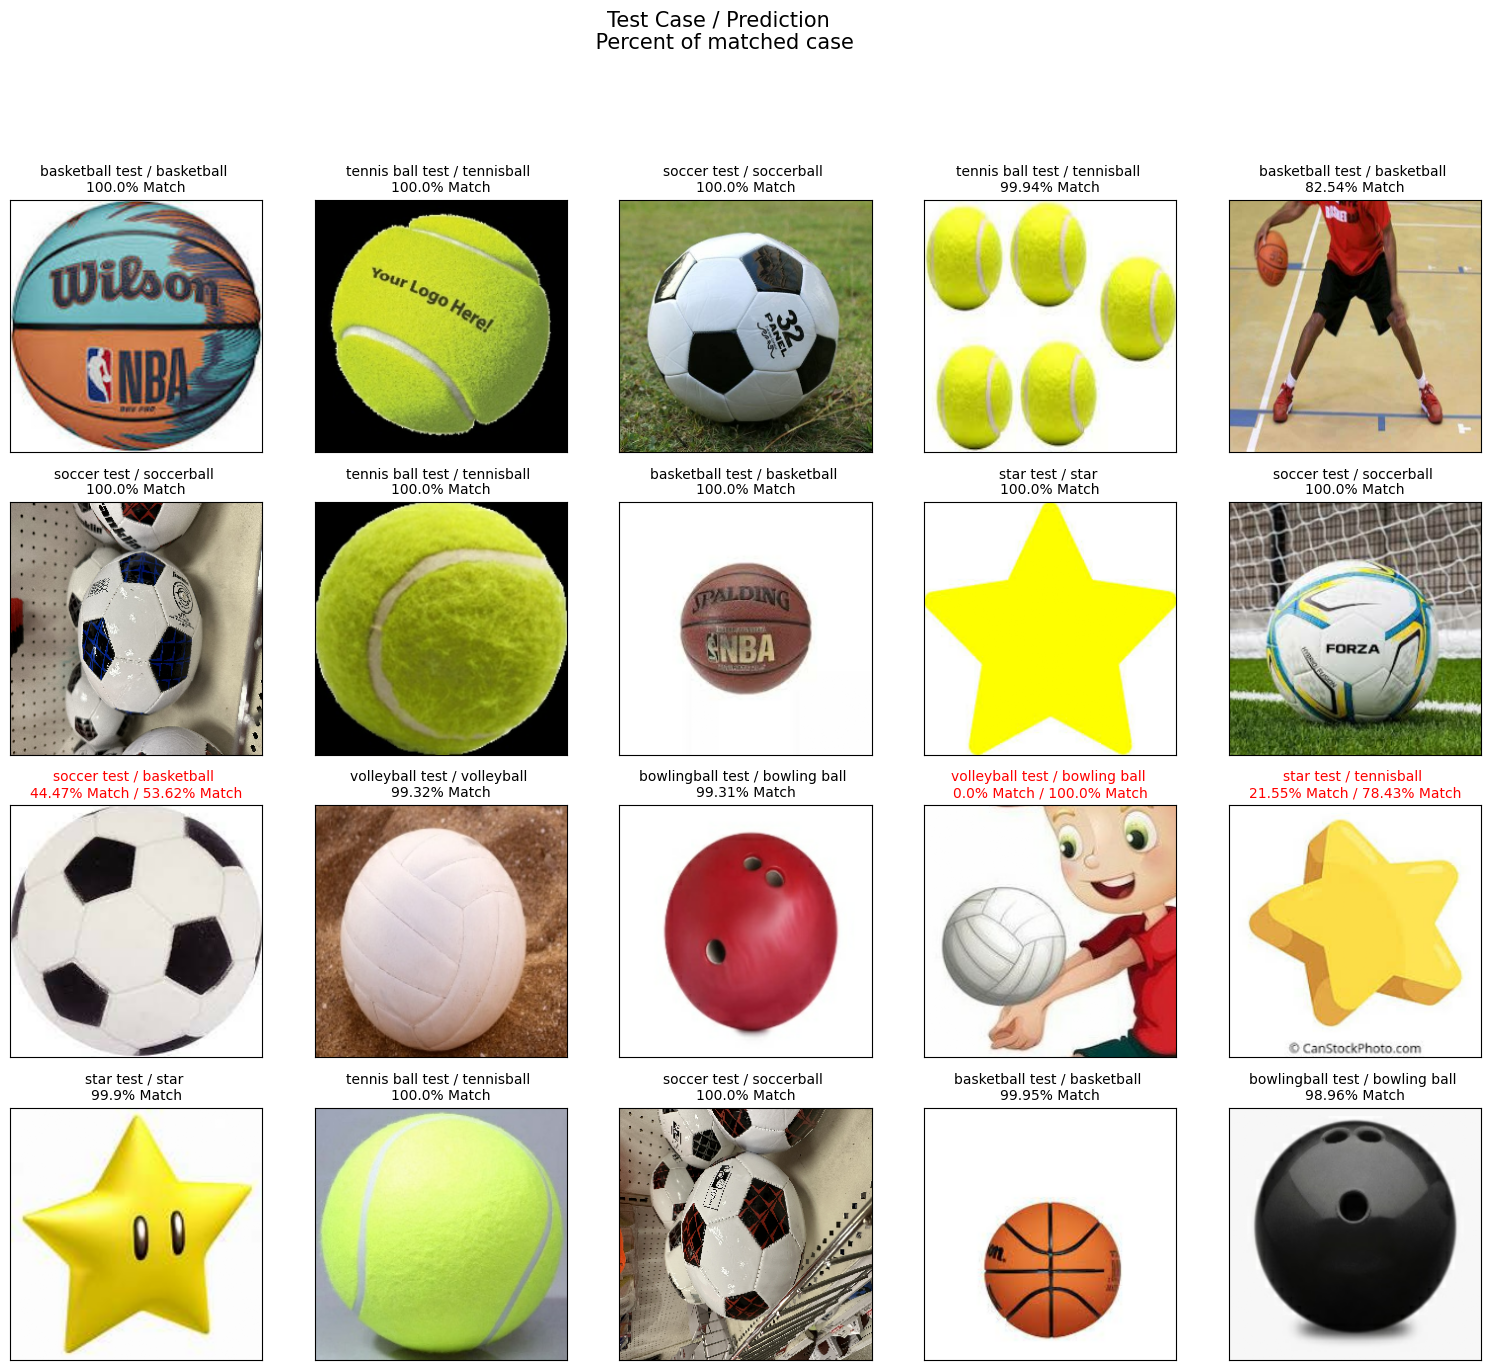

In [67]:
figsize = (19,19)
figure = plt.figure(figsize=figsize)
figure.suptitle("Test Case / Prediction \n Percent of matched case", fontsize=15)

for i in range(20):
    predict = model.predict(np.expand_dims(batch[0][i], 0), verbose = 0)
    score = tf.nn.softmax(predict[0])

    test_case = test_category[case_score[i]]
    predict_case = class_names[np.argmax(score)]
    percent_pred = round(100*np.max(score), 2)
    percent_test = round(100*np.array(score[case_score[i]]), 2)

    if(case_score[i] != np.argmax(score)):
        font_color = 'red'
        text = f"{test_case} / {predict_case} \n{percent_test}% Match / {percent_pred}% Match"
    else:
        font_color = 'black'
        text = f"{test_case} / {predict_case} \n{percent_test}% Match"
    
    plt.subplot(5,5, i+1)
    plt.title(text, fontsize=10, color=font_color)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(batch[0][i])
    
    test_list = np.append(test_list, case_score[i])
    predict_list = np.append(predict_list, np.argmax(score))

In [57]:
print(classification_report(test_list, predict_list))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87        11
         1.0       0.83      1.00      0.91         5
         2.0       1.00      0.78      0.88         9
         3.0       1.00      0.75      0.86         4
         4.0       0.75      1.00      0.86         6
         5.0       0.83      0.71      0.77         7

    accuracy                           0.86        42
   macro avg       0.88      0.86      0.86        42
weighted avg       0.87      0.86      0.86        42



In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

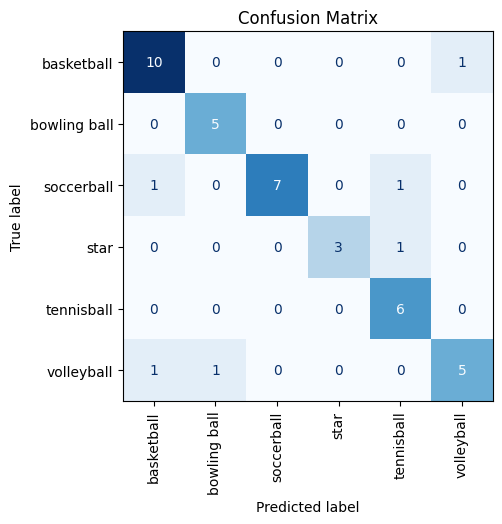

In [59]:
con_matrix = confusion_matrix(test_list, predict_list)
display_matrix = ConfusionMatrixDisplay(con_matrix, display_labels=class_names)
display_matrix.plot(colorbar=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

### 4.3 Test Single Images <a id="test_single"></a>

In [36]:
test_path = 'soccer test\\soccerball.jpg'
img = cv2.imread(os.path.join('data\\test', test_path))

resize images and setting color to RGB to match the format of our training dataset

In [37]:
resize = tf.image.resize(img, (256, 256))
resize = cv2.cvtColor(resize.numpy(), cv2.COLOR_BGR2RGB)

In [38]:
predict = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 15ms/step


In [39]:
score = tf.nn.softmax(predict[0])
test_case = os.path.dirname(test_path)
predict_case = class_names[np.argmax(score)]
percent_match = round(100 * np.max(score), 2)

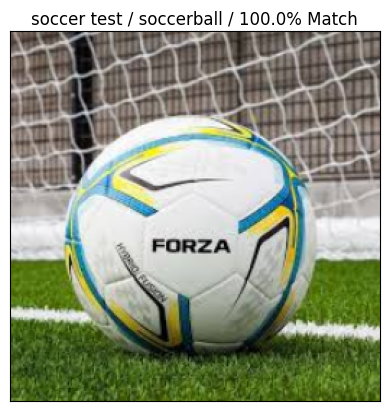

In [40]:
plt.imshow(resize.astype(int))
plt.xticks([])
plt.yticks([])
plt.title(f"{test_case} / {predict_case} / {percent_match}% Match")
plt.show()

# 5. Save Model <a id="saving_model"></a>

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models', 'imageclassification.h5'))

In [43]:
new_model = load_model('models\\imageclassification.h5')

In [44]:
predict = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 59ms/step


In [45]:
score = tf.nn.softmax(predict[0])
test_case = os.path.dirname(test_path)
predict_case = class_names[np.argmax(score)]
percent_match = round(100 * np.max(score), 2)

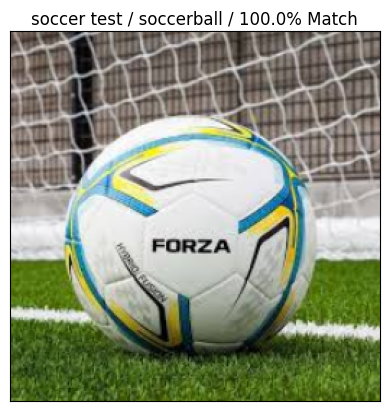

In [46]:
plt.imshow(resize.astype(int))
plt.xticks([])
plt.yticks([])
plt.title(f"{test_case} / {predict_case} / {percent_match}% Match")
plt.show()